In [113]:
import sys

In [114]:
import numpy as np
from myimgtools import *
from mymath import *
from PDHGtools import *

# Optimization problem:                                                      

#     $$ min_{u\in \Delta}  \underbrace{0.5|Au-b|_2^2}_{G} + \underbrace{\mu|Ku|_{2,1}}_{f}$$
# where $\Delta = \{u\vert 0\leq u \leq 255\}$

                                                                            

### Sadle problem
### $$\min_u\max_{p}<Ku,P>+g(u) + G(u)-f^*(p) - F(p)$$
### where $g = I_{\Delta}$ and $F\equiv 0$
### Inclusion problem
### $$T(z)+ Bz\ni 0$$
### where $z=\begin{pmatrix}u\\p\end{pmatrix}$, $T:=\begin{pmatrix} \partial I_{\Delta} &+K^*\\-K&\partial f^*(.)\end{pmatrix}$, $B:=\begin{pmatrix} A^T(Au-b) \\0\end{pmatrix}$.
We assume $B$ is lipschitz and co-coercive

#### Let us consider using PDHG method with variable metric  identity $I$ plus lower rank matrix$Q=UU^T$ multiplied by $M$
$$(M+Q)(z_{k+1}-z_{k})+T(z_{k+1})\ni -Bz_k$$
where $M$ is defined as following:
$$M=\begin{pmatrix}I/\tau&-K^*\\-K&I/\sigma\end{pmatrix}$$

### Load image

In [115]:
filename = "Diana240";
img = mpimg.imread("data/" + filename + ".png"); 
img = rgb2gray(img);
(ny,nx) = np.shape(img);
print ("image dimensions: ", np.shape(img))

image dimensions:  (240, 240)


### Construct blur kernel

In [4]:
### construction of blurr kernel ###

# filter of size 2*k+1
k = 10;
s = 2*k+1;
filter = np.zeros((s,s));

### Construct Gaussian kernel


In [5]:
if False:   # construct Gaussian kernel
    sigma = 25;

    [dx,dy] = np.meshgrid(np.linspace(-k,k,s), np.linspace(-k,k,s));
    filter = np.exp(-(dx**2+dy**2)/(2.0*sigma**2));
    filter = filter/np.sum(filter);
    print(filter)
    plt.imshow(filter);
    plt.show()

In [6]:
if True: # read filter from image
    filter_img = mpimg.imread("data/filter.png");
    s = np.shape(filter_img)[0];
    filter = filter_img/np.sum(filter_img);

### Blurr operator as matrix

In [7]:
# blurr operator as matrix
A = make_filter2D(ny, nx, filter);    

### Model blurry and noisy image 

In [8]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            
            if rdn < prob:
                output[i][j] = 0
            else:
                output[i][j] = image[i][j]
    return output

In [9]:
N = nx*ny;
# reshape to fit dimension of optimization variable
imgN=sp_noise(img,0.1)
b = imgN.reshape((N,1)); 
b = img.reshape((N,1)); 

#b=b+np.random.normal(0.0, 0.05, (N,1))Charkiw
b = A.dot(b) + np.random.normal(0.0, 0.05, (N,1));
#b=sp_noise(b,0.1)

b = b.flatten();

### Ouput blurred image

In [10]:
# write blurry image
mpimg.imsave(filename + "blurry.png", b.reshape(nx,ny), cmap=plt.cm.gray);

# Model

In [11]:
################################################################################
### Model ######################################################################

K = make_derivatives2D(ny, nx);
#mu = 0.1;


In [210]:
### Parameters
tau=0.09
sig=0.9
mu=0.001
OP={'K':K,'A':A,'b':b,'mu':mu}
Metric={'Tau':tau,'Sigma':sig,'K':K}
x=np.ones(K.shape[1])
p=np.ones(K.shape[0])
z={'x':x,'p':p}

In [211]:
import scipy as sp
eigvals, eigvecs = sp.sparse.linalg.eigsh(A, which='LM')

KeyboardInterrupt: 

In [ ]:
eigvals

In [212]:
#test####
num_x=len(x)
num_p=len(p)



Dx=np.ones(num_x)
Dp=np.ones(num_p)
U=np.zeros(num_x+num_p)
#U=-1*np.ones(num_x+num_p)
Ux=U[0:num_x]
Up=U[num_x:num_x+num_p]
Preconditioner={'U':U,'Dx':Dx,'Dp':Dp,'Ux':Ux,'Up':Up}

In [213]:
output = {
        'primal_sol': z['x'],
        'dual_sol': z['p'],
}

In [214]:
#x = output['primal_sol'];
#mpimg.imsave(filename + "reconstruction(DplusQ).png", x.reshape(ny,nx), cmap=plt.cm.gray);

In [215]:
num_x

57600

In [216]:
#Z,GAP1=PDHGoriginal(OP,Metric,z,100,1)

### 0SR1


In [217]:
def sr1(zkm1,zk,tau, gradkm1,gradk,itr,r0,U0,s,Sign):
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    xk = zk['x']
    pk = zk['p']
    yk = gradk - gradkm1
    sk = xk - xkm1
    #r = yk@sk/sk@sk
    r = 1.0
    s = (yk - r*1/tau*sk)@sk
    if s>0:
        Sign = 1
    else:
        Sign = -1
    s = np.sqrt(np.abs(s))
    if s<0.0001:
        U = np.zeros(len(xk)+len(pk))
        return U0,s,Sign,r0
    ux = (yk - 1/tau*sk)/s
    up = np.zeros(len(pk))
    U = np.concatenate([ux,up]).flatten()
    
    
    
    
    r = 5/(ux.T@ux)
    
    U = np.sqrt(r)* U
    return  U, s, Sign ,r
#     
    
    
    
    
    
    
    
    
    
    
    

In [218]:
# def sr1(zkm1,zk,tau, gradkm1,gradk,itr,r0,U0,s,Sign):
#     xkm1 = zkm1['x']
#     pkm1 = zkm1['p']
#     xk = zk['x']
#     pk = zk['p']
#     yk = gradk - gradkm1
#     sk = xk - xkm1
#     #r = yk@sk/sk@sk
#     r = 1.0
#     s = (yk - r*1/tau*sk)@sk
#     if s>0:
#         Sign = 1
#     else:
#         Sign = -1
#     s = np.sqrt(np.abs(s))
#     if s<0.0001:
#         U = np.zeros(len(xk)+len(pk))
#         return U0,s,Sign,r0
#     ux = (yk - 1/tau*sk)/s
#     up = np.zeros(len(pk))
#     U = np.concatenate([ux,up]).flatten()
    
    
    
    
#     r = 1/(ux.T@ux)
#     r = min(r ,1/(1+itr)**2)
#     U = np.sqrt(r)* U
#     return  U, s, Sign ,r
# #     
    

In [219]:
# def sr1(zkm1,zk,tau, gradkm1,gradk,itr,r0,U0,s,Sign):
#     xkm1 = zkm1['x']
#     pkm1 = zkm1['p']
#     xk = zk['x']
#     pk = zk['p']
#     yk = gradk - gradkm1
#     sk = xk - xkm1
#     #r = yk@sk/sk@sk
#     r = 1.0
#     s = (yk - r*1/tau*sk)@sk
#     if s>0:
#         Sign = 1
#     else:
#         Sign = -1
#     s = np.sqrt(np.abs(s))
#     if s<0.0001:
#         U = np.zeros(len(xk)+len(pk))
#         return U0,s,Sign,r0
#     ux = (yk - 1/tau*sk)/s
#     up = np.zeros(len(pk))
#     U = np.concatenate([ux,up]).flatten()
    
    
    
# #     if itr <400:
# #         r = (0.7/(tau))/(ux.T@ux)
    
# #         U = r* U
# #         return  U, s, Sign ,r
#     # compute scaling r
#     if norm(U0)!=0:
#         U0hat = U0/norm(U0)
#         temp = U@U0hat
#         Uhat = U - temp * U0
#         Uhat = Uhat/norm(Uhat)
#         lbda1 = U@U0hat
#         lbda2 = U@Uhat
        
        
#         if lbda1 == 0:
#             r = (1/itr**2)/lbda2**2
#             U = np.sqrt(r)* U
            
#             return U, s, Sign ,r
#         if lbda2 == 0:

#             r = r0*norm(U0)**2/lbda1**2
#             U = np.sqrt(r)*U
#             return U0, s, Sign ,r
#         r1 = (0.7/(tau))/(ux.T@ux)
    
#         r2 = r0*norm(U0)**2/lbda1**2
#         r = min(r1,r2)
#         s = (1/itr)/np.sqrt(r)
#         U = np.sqrt(r)*(lbda1*U0hat + s * lbda2*Uhat )
        
#         return  U, s, Sign ,r
#     return  0*U0, s, Sign ,r0

In [220]:
def LfunctionMplusQ(Preconditioner,OP,Metric,z_init,a,Sign,gradk):
    #Load parameters
    Dx=Preconditioner['Dx']
    
    Dp=Preconditioner['Dp']
    
    z = z_init.copy()
    #U=Preconditioner['U']
    #u=Preconditioner['Ux']
    #v=Preconditioner['Up']
    U=Preconditioner['U']
    #######
#     num_x=len(Dx)
#     num_p=len(Dp)
    ##### 
    #ztemp={'x':Dx*z['x']-Ux*a,'p':Dp*z['p']-Up*a}
    ztemp={'x':z['x'],'p':z['p']}
    if Sign==1:
        zafter=PDHG_MQ(OP,Metric,ztemp,U*a,gradk)#U*a
    else:
        zafter=PDHG_MQ(OP,Metric,ztemp,-U*a,gradk)#U*a
    
    #####
    x=zafter['x']
    p=zafter['p']
   
    JTM=np.concatenate([x,p])
    JTM.flatten()
    D=np.concatenate([Dx,Dp])
    D.flatten()
    #U=np.concatenate([u,v])
    #U.flatten()
    #return U.T.dot(1/D*JTM-U*a)-a
    Zk = np.concatenate([z['x'],z['p']]).flatten()
   
    return    U.T.dot(JTM-Zk)-a #U.T.dot(1/D*JTM-U*a)-a

In [221]:
def PDHG_MQ(OP,Metric,z_init,y,gradk):
    
    
    #Load parameters
    tau=Metric['Tau']
    sig=Metric['Sigma']
    mu=OP['mu']
    K=OP['K']
    A=OP['A']
    b=OP['b']
    
    z = z_init.copy()
    # initialization
    x=z['x']
    p=z['p']
    
    
    num_x=len(x)
    num_p=len(p)
    
    y1=y[0:num_x]
    y2=y[num_x:(num_x+num_p)]
    xk=x
    pk=p

    #PDHG
    ######################        primal          ################################
    #xkp1=xk-tau*K.T.dot(pk)-tau*A.T.dot(qk)
    xkp1 = np.minimum((-tau*y1-tau*K.T.dot(pk) - tau*gradk + xk), 255)
    xkp1 = np.maximum( xkp1, 0)
    
    
    
    ######################        dual p          ################################
    D=np.ones(num_p)
    #pkp1=prox_proj_ball((pk+sig*K.dot(2*xkp1-xk)),mu)
    #pkp1=proxP_conjf(D,pk+sig*K.dot(2*xkp1-xk),mu)
    p_temp=pk+sig*(K.dot(2*xkp1-xk))-sig*y2#2*x_kp1-x_k
        
    #prox_proj(p_temp)_onto_ball with radius mu
    pkp1=prox_proj_ball(p_temp,mu)
    
   
    zkp1={'x':xkp1,'p':pkp1}
    return zkp1

The following uses NewtonMethod to solve rootfinding problem

In [222]:
def MQRootfinding_N(Preconditioner,OP,Metric,z_init, Sign,gradk,tol):
    maxiter =200
    #load parameter
    z = z_init.copy()
    U = Preconditioner['U']
    Ux = U[0:len(z['x'])]
    
    tau=Metric['Tau']
    sig=Metric['Sigma']
    mu=OP['mu']
    K=OP['K']
    #compute current value curr , (prox(v))
    curr = z['x'] - tau * gradk- K.T@z['p']
    #compute [-delta,delta]
    #delta = np.min((np.min(np.abs(curr)),np.min(np.abs(curr-255))))
    #print('delta',delta)
    #bisection
    #a0 = MQRootfinding(Preconditioner,OP,Metric,z, Sign,gradk,delta+tol)
    
    #test
    #######
    a0 = 0#
    #######
    
    #Hessian
    curr=curr-Sign*tau*Ux*a0
    Hessian = -Sign*Ux@((curr>0)*(curr<255)*Ux)-1
    
    #Newton-Method
    #val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a0,Sign,gradk)
    #if (val_L<tol):
    #    return a0
    #else:
    #    a = a0
    #    k = 0
    #    while k<maxiter:
#             k = k+1
#             a = a - val_L/Hessian
#             val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
#             if val_L<tol:
#                 return a 
    
    ########################################### test ############################3
    a = MQRootfinding(Preconditioner,OP,Metric,z_init, Sign,gradk,tol,5)
    k = 0
    val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
    #print('val_L=',val_L)
    while k<maxiter:
        curr=curr-Sign*tau*Ux*a0
        Hessian = -Sign*tau*Ux@((curr>0)*(curr<255)*Ux)-1
        k = k+1
        a = a - val_L/Hessian
        val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
        #print('val_L',val_L)
        if np.abs(val_L)<100*tol:
            return a 

The following uses Bisection to solve rootfinding problem

In [223]:
def MQRootfinding(Preconditioner,OP,Metric,z_init, Sign,gradk,tol,maxit):
    # we are going to use bisection method to solve L=0 when r=1
    #nonzeroL    = find( abs(L) > 100*np.finfo(float).eps );
    
    
    
    #Load parameters
    U=Preconditioner['U']
    
    z = z_init.copy()
    
    x0=np.concatenate([z['x'],z['p']])
    
    
    #before processing
    
    bound=100+norm(U)*(2*norm(x0))#+norm(ProxB_l1(0,tau,D)))# coRootfinding_r1(x,D,v,tau,maxit):upute the bound before using bisection method
    k=0

    if LfunctionMplusQ(Preconditioner,OP,Metric,z,bound,Sign,gradk) >0:
        c1=-bound
        c2=bound
    else:
        c1=bound
        c2=-bound
    ak=bound
    
    while k<maxit:
        k=k+1
        akm1=ak
        ak=(c1+c2)/2
        #print('C2=%.3f,ak=%.3f'%(c2,ak))
        if LfunctionMplusQ(Preconditioner,OP,Metric,z,ak,Sign,gradk)>0:
            c2=ak
        else:
            c1=ak
        diff=np.abs(ak-akm1)
        if (k>1)&(diff<tol):
            return ak
    return ak

In [229]:
def PDHG_MplusQ(Preconditioner, OP,Metric,z_initial,NumOfIter,check=10,Sign=1,condition=0,acc=0,rlx=0,nacc=0):
    #M=Dx+uu^T    -K^*
    #   -K             Dy+vv^T
    ######## loading ###############
    
    U = Preconditioner['U']
    z = z_initial.copy() 
    
    r = 1
    s = 0
    Tau=Metric['Tau']
    Sig=Metric['Sigma']
    K=Metric['K']
    num_x=len(Dx)
    num_p=len(Dp)
    u=U[0:num_x]
    v=U[(num_x):(num_p+num_x)]
    x=z['x']
    p=z['p']
    z0=z.copy()
    z_1=z.copy()
    b = OP['b']
    gradk = A.T@(A@z['x']-b)
    a = 0
    alphak = 0
    
    
    tol=1*np.finfo(float).eps
    gap=cal_primal_dual_gap_ROF(A,K,b,z['x'],z['p'],OP['mu'])
    GAP=[gap]
    Alphak = []
    print ('iter:start, gap: %f' %  gap)
    ITER = 0
    for iter in range(NumOfIter):
        z_1=z0
        z0=z.copy()
        gradkm1 = gradk.copy()
        ####### accelerate ######
        if (acc==1)&(iter>0):
            
            
            
            #1. compute ||z_k -z_{k-1}||
            square_of_diff= (z0['x'] - z_1['x'])@(z0['x'] - z_1['x'])+(z0['p'] - z_1['p'])@(z0['p'] - z_1['p'])
            max_diff = np.max((np.sqrt(square_of_diff),square_of_diff))
                
            
            #2. compute accelerate param: ac    
#             if max_diff<1:
#                 if ITER == 0:
#                     ITER = iter
#                 ac = 1/((iter-ITER+1)**(1.1)*(max_diff))
#             else:
#                 ac = 0
            ac =  10/((iter)**(1.1)*(max_diff))
                
            #print('accelerated',max_diff)
            #3. compute extrapolation
            z['x'] = z0['x'] + ac*(z0['x'] - z_1['x'])
            z['p'] = z0['p'] + ac*(z0['p'] - z_1['p'])
            #### update grad ########
            gradk = A.T@(A@z['x']-b)
            #########################
        
        #########################
        # calculating a
        tol=1*np.finfo(float).eps
        a = MQRootfinding_N(Preconditioner,OP,Metric,z, Sign,gradk,tol)
        val_L=LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
#         if(iter % check == 0):
#             print('L value=%f'%val_L) 
        #a=MQRootfinding(Preconditioner,OP,Metric,z0,Sign,gradk,tol)
        #########################
        if Sign==-1:
            y=-U*a#U*a
        else:
            y=U*a
        #########################
        z=PDHG_MQ(OP,Metric,z,y,gradk)
        
        ####### accelerate ######
        if nacc=='nesterov':
            z['x'] = z['x'] + (iter-2)/((iter+1))*(z['x'] - z0['x'])
            z['p'] = z['p'] + (iter-2)/((iter+1))*(z['p'] - z0['p'])
#         if acc:
#             z['x'] = z['x'] + acc/((iter+1))*(z['x'] - z0['x'])
#             z['p'] = z['p'] + acc/((iter+1))*(z['p'] - z0['p'])
#         #### update grad ########
#         gradk = A.T@(A@z['x']-b)
        ####### relaxation ######
        if rlx == 1:
            alphak,v_x,v_p = cal_param(z,z0,gradk,gradkm1, Metric)
            z = relx_step(z,z0,alphak,v_x,v_p)
            Alphak.append(alphak)
        #########################################
        #checking breaking condition
        gap=cal_primal_dual_gap_ROF(A,K,b,z['x'],z['p'],OP['mu'])
        
        if (iter % check == 0):
            print ('iter: %d, gap: %f' % (iter, gap));
            GAP.append(gap)
        if (gap < tol):
            breakvalue = 1;
            break;
        #### update grad ########
        gradk = A.T@(A@z['x']-b)
        ############ updating U######################
        
        
        if iter>2:
            U,s,Sign,r = sr1(z0,z,tau, gradkm1,gradk,iter,r,U/r,s,Sign)
            if condition ==0:
                U = 0*U
            
        
            
            
        #Tempx=(2*z0['x']-1*z['x']-z_1['x'])
        #Tempp=(2*z0['p']-1*z['p']-z_1['p'])
        #Ux=((1/Tau*Tempx-K.T.dot(Tempp))) #+K.T.dot(z0['p']-z['p']) )
       
        #Up=((-K.dot(Tempx)+1/Sig*Tempp) ) #+ K.dot(z['x']-z0['x']) )
        
        #scaling=Ux.dot((z['x']-z0['x']))+Up.dot((z['p']-z0['p']))
        ##############################################
        
        #if scaling>0:
            #Sign=1
        #else:
            #Sign=1
            #scaling=np.abs(scaling)
            
        #Ux=1000*Ux
        #Up=1000*Up
        #U=(np.concatenate([Ux,Up])).flatten()
        Preconditioner['U']=U#(np.concatenate([Ux,Up])).flatten()
        
        ######################################
    #########################################
    return z, GAP, Alphak

\begin{equation}
\begin{split}
b_k&:=\langle z_k-\hat z_k,M_k(z_k-\hat z_k)-B(z_k)+B(\hat z_k) \rangle\\
a&:=\vert\vert M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)\vert\vert ^2\\
\end{split}
\end{equation}
$$v:=M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)$$
$$\alpha_k = \frac{b_k}{a}$$

In [230]:
def cal_param(zk,zkm1,gradk,gradkm1, Metric):
    # compute the parameter $alpha_k$
    #input:
    #output: alpha_k
    #load parameters 
    Tau = Metric['Tau']
    Sig = Metric['Sigma']
    K = Metric['K']
    #load input
    xk = zk['x']
    pk = zk['p']
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    # z-hat z
    d_x = xkm1 - xk
    d_p = pkm1 - pk
    #compute vector v
    v_x = 1/Tau * (d_x) - K.T@(d_p) + gradk -gradkm1
    v_p = 1/Sig * (d_p) - K@(d_x)
    #compute a 
    a = v_x@v_x + v_p@v_p
    #compute b_k
    bk = d_x@v_x + d_p@v_p
    return bk/a,v_x,v_p

In [231]:
def relx_step(zk,zkm1,alphak,v_x,v_p):
    zk['x'] = zkm1['x'] - 0.5*alphak*(v_x)
    zk['p'] = zkm1['p'] - 0.5*alphak*(v_p)
    return zk

In [227]:
 Zmq,GAP,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,10000,10,0,0,0)

iter:start, gap: 9472.931900
iter: 0, gap: 7877.915597
iter: 10, gap: 1330.816132
iter: 20, gap: 294.700693
iter: 30, gap: 121.751434
iter: 40, gap: 88.211371
iter: 50, gap: 78.906420
iter: 60, gap: 74.653893
iter: 70, gap: 71.902251
iter: 80, gap: 69.824619
iter: 90, gap: 68.144265
iter: 100, gap: 66.733635
iter: 110, gap: 65.519487
iter: 120, gap: 64.454873
iter: 130, gap: 63.507824
iter: 140, gap: 62.656537
iter: 150, gap: 61.883634
iter: 160, gap: 61.176532
iter: 170, gap: 60.525733
iter: 180, gap: 59.923781
iter: 190, gap: 59.364342
iter: 200, gap: 58.842070
iter: 210, gap: 58.352984
iter: 220, gap: 57.893684
iter: 230, gap: 57.461129
iter: 240, gap: 57.053141
iter: 250, gap: 56.667265
iter: 260, gap: 56.301640
iter: 270, gap: 55.954665
iter: 280, gap: 55.625122
iter: 290, gap: 55.311369
iter: 300, gap: 55.012430
iter: 310, gap: 54.727171
iter: 320, gap: 54.454571
iter: 330, gap: 54.194064
iter: 340, gap: 53.944875
iter: 350, gap: 53.706159
iter: 360, gap: 53.477445
iter: 370, gap

iter: 3070, gap: 45.432324
iter: 3080, gap: 45.430600
iter: 3090, gap: 45.428895
iter: 3100, gap: 45.427208
iter: 3110, gap: 45.425541
iter: 3120, gap: 45.423892
iter: 3130, gap: 45.422261
iter: 3140, gap: 45.420648
iter: 3150, gap: 45.419053
iter: 3160, gap: 45.417475
iter: 3170, gap: 45.415914
iter: 3180, gap: 45.414370
iter: 3190, gap: 45.412842
iter: 3200, gap: 45.411330
iter: 3210, gap: 45.409835
iter: 3220, gap: 45.408356
iter: 3230, gap: 45.406892
iter: 3240, gap: 45.405444
iter: 3250, gap: 45.404010
iter: 3260, gap: 45.402593
iter: 3270, gap: 45.401189
iter: 3280, gap: 45.399801
iter: 3290, gap: 45.398427
iter: 3300, gap: 45.397068
iter: 3310, gap: 45.395723
iter: 3320, gap: 45.394393
iter: 3330, gap: 45.393077
iter: 3340, gap: 45.391774
iter: 3350, gap: 45.390486
iter: 3360, gap: 45.389210
iter: 3370, gap: 45.387949
iter: 3380, gap: 45.386701
iter: 3390, gap: 45.385467
iter: 3400, gap: 45.384245
iter: 3410, gap: 45.383036
iter: 3420, gap: 45.381840
iter: 3430, gap: 45.380656
i

iter: 6110, gap: 45.265319
iter: 6120, gap: 45.265202
iter: 6130, gap: 45.265086
iter: 6140, gap: 45.264971
iter: 6150, gap: 45.264856
iter: 6160, gap: 45.264743
iter: 6170, gap: 45.264630
iter: 6180, gap: 45.264518
iter: 6190, gap: 45.264406
iter: 6200, gap: 45.264296
iter: 6210, gap: 45.264186
iter: 6220, gap: 45.264077
iter: 6230, gap: 45.263969
iter: 6240, gap: 45.263862
iter: 6250, gap: 45.263755
iter: 6260, gap: 45.263649
iter: 6270, gap: 45.263544
iter: 6280, gap: 45.263440
iter: 6290, gap: 45.263336
iter: 6300, gap: 45.263233
iter: 6310, gap: 45.263131
iter: 6320, gap: 45.263029
iter: 6330, gap: 45.262929
iter: 6340, gap: 45.262828
iter: 6350, gap: 45.262729
iter: 6360, gap: 45.262630
iter: 6370, gap: 45.262532
iter: 6380, gap: 45.262435
iter: 6390, gap: 45.262338
iter: 6400, gap: 45.262242
iter: 6410, gap: 45.262147
iter: 6420, gap: 45.262052
iter: 6430, gap: 45.261958
iter: 6440, gap: 45.261864
iter: 6450, gap: 45.261772
iter: 6460, gap: 45.261680
iter: 6470, gap: 45.261588
i

iter: 9150, gap: 45.249810
iter: 9160, gap: 45.249792
iter: 9170, gap: 45.249773
iter: 9180, gap: 45.249755
iter: 9190, gap: 45.249736
iter: 9200, gap: 45.249718
iter: 9210, gap: 45.249700
iter: 9220, gap: 45.249682
iter: 9230, gap: 45.249664
iter: 9240, gap: 45.249646
iter: 9250, gap: 45.249629
iter: 9260, gap: 45.249611
iter: 9270, gap: 45.249593
iter: 9280, gap: 45.249576
iter: 9290, gap: 45.249559
iter: 9300, gap: 45.249541
iter: 9310, gap: 45.249524
iter: 9320, gap: 45.249507
iter: 9330, gap: 45.249490
iter: 9340, gap: 45.249473
iter: 9350, gap: 45.249456
iter: 9360, gap: 45.249439
iter: 9370, gap: 45.249423
iter: 9380, gap: 45.249406
iter: 9390, gap: 45.249390
iter: 9400, gap: 45.249373
iter: 9410, gap: 45.249357
iter: 9420, gap: 45.249340
iter: 9430, gap: 45.249324
iter: 9440, gap: 45.249308
iter: 9450, gap: 45.249292
iter: 9460, gap: 45.249276
iter: 9470, gap: 45.249260
iter: 9480, gap: 45.249244
iter: 9490, gap: 45.249229
iter: 9500, gap: 45.249213
iter: 9510, gap: 45.249197
i

In [232]:
Preconditioner['U']=np.zeros(num_x+num_p)
maxiter = 2000
#Zmq2,GAP2,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,0,0) #original
Zmq3,GAP3,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,1) #inertial+QN
Zmq4,GAP4,Alphak=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,0,1)#relaxation
Zmq5,GAP5,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,0) #QN
#

iter:start, gap: 9472.931900
iter: 0, gap: 7877.915597
iter: 10, gap: 474.833379
iter: 20, gap: 94.392373
iter: 30, gap: 74.027892
iter: 40, gap: 67.654416
iter: 50, gap: 63.942521
iter: 60, gap: 61.383976
iter: 70, gap: 59.462121
iter: 80, gap: 57.942671
iter: 90, gap: 56.700901
iter: 100, gap: 55.661940
iter: 110, gap: 54.777109
iter: 120, gap: 54.013048
iter: 130, gap: 53.346336
iter: 140, gap: 52.758965
iter: 150, gap: 52.237194
iter: 160, gap: 51.770624
iter: 170, gap: 51.350309
iter: 180, gap: 50.969636
iter: 190, gap: 50.623450
iter: 200, gap: 50.307740
iter: 210, gap: 50.018764
iter: 220, gap: 49.753315
iter: 230, gap: 49.508801
iter: 240, gap: 49.283006
iter: 250, gap: 49.073992
iter: 260, gap: 48.879902
iter: 270, gap: 48.699316
iter: 280, gap: 48.531206
iter: 290, gap: 48.374403
iter: 300, gap: 48.227805
iter: 310, gap: 48.090531
iter: 320, gap: 47.961751
iter: 330, gap: 47.840912
iter: 340, gap: 47.727287
iter: 350, gap: 47.620242
iter: 360, gap: 47.519370
iter: 370, gap: 4

iter: 1100, gap: 45.573659
iter: 1110, gap: 45.565756
iter: 1120, gap: 45.558090
iter: 1130, gap: 45.550651
iter: 1140, gap: 45.543433
iter: 1150, gap: 45.536427
iter: 1160, gap: 45.529626
iter: 1170, gap: 45.523022
iter: 1180, gap: 45.516607
iter: 1190, gap: 45.510377
iter: 1200, gap: 45.504325
iter: 1210, gap: 45.498446
iter: 1220, gap: 45.492735
iter: 1230, gap: 45.487185
iter: 1240, gap: 45.481789
iter: 1250, gap: 45.476544
iter: 1260, gap: 45.471443
iter: 1270, gap: 45.466480
iter: 1280, gap: 45.461652
iter: 1290, gap: 45.456957
iter: 1300, gap: 45.452391
iter: 1310, gap: 45.447948
iter: 1320, gap: 45.443625
iter: 1330, gap: 45.439419
iter: 1340, gap: 45.435323
iter: 1350, gap: 45.431336
iter: 1360, gap: 45.427456
iter: 1370, gap: 45.423679
iter: 1380, gap: 45.420000
iter: 1390, gap: 45.416417
iter: 1400, gap: 45.412926
iter: 1410, gap: 45.409523
iter: 1420, gap: 45.406206
iter: 1430, gap: 45.402972
iter: 1440, gap: 45.399820
iter: 1450, gap: 45.396749
iter: 1460, gap: 45.393753
i

In [ ]:
Zmq4,GAP4,Alphak=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,0,1)#relaxation

In [233]:
#Zmq6,GAP6=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,0,0,0,'nesterov') #inertial

Zmq7,GAP7,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,0,1)

iter:start, gap: 9472.931900
iter: 0, gap: 7877.914479
iter: 10, gap: 1274.683857
iter: 20, gap: 267.005302
iter: 30, gap: 106.719474
iter: 40, gap: 80.321928
iter: 50, gap: 73.137583
iter: 60, gap: 69.190782
iter: 70, gap: 66.461372
iter: 80, gap: 64.399857
iter: 90, gap: 62.758103
iter: 100, gap: 61.402971
iter: 110, gap: 60.255223
iter: 120, gap: 59.264778
iter: 130, gap: 58.396730
iter: 140, gap: 57.627223
iter: 150, gap: 56.938804
iter: 160, gap: 56.317916
iter: 170, gap: 55.754435
iter: 180, gap: 55.240091
iter: 190, gap: 54.768340
iter: 200, gap: 54.333614
iter: 210, gap: 53.931889
iter: 220, gap: 53.559294
iter: 230, gap: 53.212628
iter: 240, gap: 52.889277
iter: 250, gap: 52.586756
iter: 260, gap: 52.303130
iter: 270, gap: 52.036802
iter: 280, gap: 51.785824
iter: 290, gap: 51.548942
iter: 300, gap: 51.325023
iter: 310, gap: 51.112903
iter: 320, gap: 50.911778
iter: 330, gap: 50.720832
iter: 340, gap: 50.539274
iter: 350, gap: 50.366706
iter: 360, gap: 50.202401
iter: 370, gap

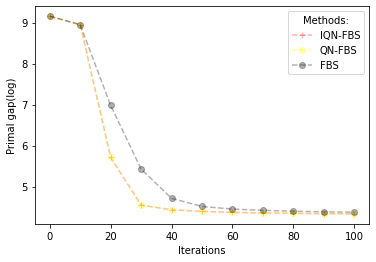

In [373]:
maxnum = 11#len(GAP2[0:300])
x_axis=np.arange(0,110,10)

plt.plot(x_axis,np.log(np.array(GAP3[0:maxnum])), '+--', color='red', alpha=0.3, label='IQN-FBS')
plt.plot(x_axis,np.log(np.array(GAP5[0:maxnum])), 'o--', color='yellow', alpha=0.3, label='QN-FBS')
#plt.plot(x_axis,np.log(np.array(GAP6[0:maxnum])), '*--', color='purple', alpha=0.3, label='IFBS')
plt.plot(x_axis,np.log(np.array(GAP2[0:maxnum])), 'o--', color='black', alpha=0.3, label='FBS')
#plt.plot(x_axis,np.log(np.array(GAP4[0:maxnum])), 'o--', color='green', alpha=0.3, label='R-FBS')
plt.xlabel('Iterations')
plt.ylabel('Primal gap(log)')
#plt.title('Convergence')
plt.legend(title='Methods:')
#plt.savefig('Image-deconcolution(BisectionAndConvergence).pdf')
plt.show()

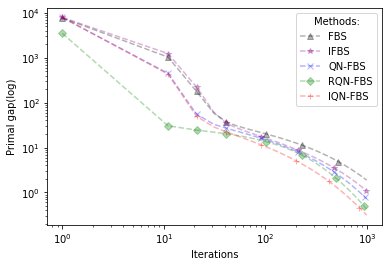

In [239]:
maxnum =int(1000/10) #int(2000/10)#len(GAP2[0:300])
#maxnum = maxnum+1
x_axis=np.arange(0,1000,10)+1
standard_line = 10**5/(x_axis**2)

#plt.loglog(x_axis,standard_line, '-',markevery=0.2, color='black', alpha=0.3, label='O(1/k^2)')

#plt.loglog(x_axis[0:1000],(np.array(GAP4[1:1000+1])-GAP[-1]), 'D--',markevery=0.1, color='green', alpha=0.3, label='RQN-FBS')
plt.loglog(x_axis,(np.array(GAP2[1:maxnum+1])-GAP[-1]), '^--',markevery=0.1, color='black', alpha=0.3, label='FBS')
plt.loglog(x_axis,(np.array(GAP7[1:maxnum+1])-GAP[-1]), '*--',markevery=0.1, color='purple', alpha=0.3, label='IFBS')
plt.loglog(x_axis,(np.array(GAP5[1:maxnum+1])-GAP[-1]), 'x--',markevery=0.1, color='blue', alpha=0.3, label='QN-FBS')

plt.loglog(x_axis,(np.array(GAP4[1:maxnum+1])-GAP[-1]), 'D--',markevery=0.1, color='green', alpha=0.3, label='RQN-FBS')

plt.loglog(x_axis,(np.array(GAP3[1:maxnum+1])-GAP[-1]), '+--', markevery=0.1,color='red', alpha=0.3, label='IQN-FBS')



plt.xlabel('Iterations')
plt.ylabel('Primal gap(log)')
#plt.title('Convergence')
plt.legend(title='Methods:')
plt.savefig('Image-deconcolution(NewtonAndWithoutConvAssumpNewAlg0.09-0.9-0.001).pdf')
plt.show()

In [33]:
AK = []
for i in range(2000):
    if i%10==0:
        AK.append(Alphak[i])

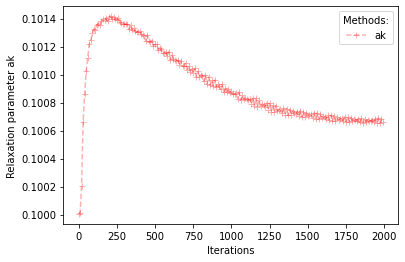

In [34]:
x_axis=np.arange(0,2000,10)
plt.plot(x_axis,(np.array(AK[0:200])), '+--', color='red', alpha=0.3, label='ak')
plt.xlabel('Iterations')
plt.ylabel('Relaxation parameter ak')
#plt.title('Convergence')
plt.legend(title='Methods:')
plt.savefig('Image-deconcolution(RelaxationParameter).pdf')
plt.show()

In [62]:
Preconditioner['U']=np.zeros(num_x+num_p)
Zmq2,GAP2=PDHG_MplusQ(Preconditioner, OP,Metric,z,500,10,0,0,0) #original
Zmq3,GAP3=PDHG_MplusQ(Preconditioner, OP,Metric,z,500,10,0,1,2) #inertial
Zmq4,GAP4=PDHG_MplusQ(Preconditioner, OP,Metric,z,500,10,0,1,0,1)#relaxation


iter: 0, gap: 6373.743712
iter: 10, gap: 878.111545
iter: 20, gap: 199.754404
iter: 30, gap: 107.227556
iter: 40, gap: 90.624182
iter: 50, gap: 85.557100
iter: 60, gap: 83.008108
iter: 70, gap: 81.368933
iter: 80, gap: 80.202713
iter: 90, gap: 79.325689
iter: 100, gap: 78.642965
iter: 110, gap: 78.096423
iter: 120, gap: 77.649886
iter: 130, gap: 77.279072
iter: 140, gap: 76.966764
iter: 150, gap: 76.699757
iter: 160, gap: 76.470276
iter: 170, gap: 76.271149
iter: 180, gap: 76.097480
iter: 190, gap: 75.944353
iter: 200, gap: 75.808806
iter: 210, gap: 75.687801
iter: 220, gap: 75.579737
iter: 230, gap: 75.483180
iter: 240, gap: 75.396120
iter: 250, gap: 75.317393
iter: 260, gap: 75.246029
iter: 270, gap: 75.181343
iter: 280, gap: 75.122377
iter: 290, gap: 75.068838
iter: 300, gap: 75.019586
iter: 310, gap: 74.974324
iter: 320, gap: 74.932557
iter: 330, gap: 74.894072
iter: 340, gap: 74.858752
iter: 350, gap: 74.825968
iter: 360, gap: 74.795681
iter: 370, gap: 74.767571
iter: 380, gap: 74

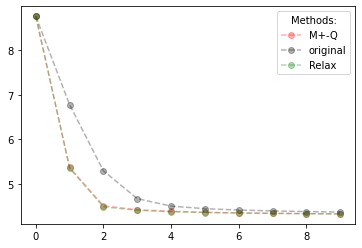

In [63]:
#### update grad ########
#         gradk = A.T@(A@z['x']-b)x_axis=np.arange(len(GAP2[0:10]))

plt.plot(x_axis,np.log(np.array(GAP3[0:10])), 'o--', color='red', alpha=0.3, label='M+-Q')
    
plt.plot(x_axis,np.log(np.array(GAP2[0:10])), 'o--', color='black', alpha=0.3, label='original')
plt.plot(x_axis,np.log(np.array(GAP4[0:10])), 'o--', color='green', alpha=0.3, label='Relax')

plt.legend(title='Methods:')
plt.show()

In [236]:
x = Zmq3['x'];
mpimg.imsave(filename + "reconstruction(deblurring).jpg", x.reshape(ny,nx), cmap=plt.cm.gray);

In [237]:
x = Zmq['x'];
mpimg.imsave(filename + "reconstruction(deblurringOriginal).jpg", x.reshape(ny,nx), cmap=plt.cm.gray);

In [238]:
x = Zmq4['x'];
mpimg.imsave(filename + "reconstruction(deblurringRelax).jpg", x.reshape(ny,nx), cmap=plt.cm.gray);